In [1]:
from keras.applications.xception import Xception
from keras.applications import ResNet50V2
from keras.callbacks import ModelCheckpoint
from keras.engine import Input
from keras.layers import GlobalAveragePooling2D, Dense, Reshape, Lambda, LSTM
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
from keras.layers import merge
import time
import numpy as np

np.random.seed(1337)

Using TensorFlow backend.


In [2]:
import keras
import keras.utils
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
import sys
import os

In [4]:
train_datagen = ImageDataGenerator(
    validation_split=0.3)

In [5]:
dirname = 'D:/200X200'
dir_chess_folders = os.listdir(dirname)
dir_chess_paths = [os.path.join(dirname, path) for path in dir_chess_folders]
dir_chess_paths

['D:/200X200\\cloudy',
 'D:/200X200\\haze',
 'D:/200X200\\rainy',
 'D:/200X200\\snow',
 'D:/200X200\\sunny',
 'D:/200X200\\thunder']

In [6]:
batch_size_phase_one = 32
batch_size_phase_two = 16
nb_val_samples = 100

nb_epochs = 5

img_width = 200
img_height = 200

In [7]:
def get_training_generator_test(batch_size=128):
    train_generator_test = train_datagen.flow_from_directory(
    dirname,
    target_size=(img_width, img_height),
    class_mode='categorical',
    subset='training',
    batch_size=batch_size)

    val_generator_test = train_datagen.flow_from_directory(
    dirname,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,)
    return train_generator_test, val_generator_test

In [8]:
# Loading dataset
print("Loading the dataset with batch size of {}...".format(batch_size_phase_one))
train_generator_test, val_generator_test = get_training_generator_test(batch_size_phase_one)
print("Dataset loaded")

print("Building model...")
input_tensor = Input(shape=(img_width, img_height, 3))

Loading the dataset with batch size of 32...
Found 42000 images belonging to 6 classes.
Found 18000 images belonging to 6 classes.
Dataset loaded
Building model...


In [9]:
# Creating CNN
cnn_model = ResNet50V2(weights='imagenet', include_top=False, input_tensor=input_tensor)
x = cnn_model.output
cnn_bottleneck = GlobalAveragePooling2D()(x)

In [10]:
# Make CNN layers not trainable
for layer in cnn_model.layers:
    layer.trainable = False

In [11]:
# Creating RNN
x=input_tensor
x = Reshape((30, 4000))(x)  # 23 timesteps, input dim of each timestep 3887
x = LSTM(2048, return_sequences=True)(x)
rnn_output = LSTM(2048)(x)

In [12]:
# Merging both cnn bottleneck and rnn's output wise element wise multiplication
x = keras.layers.concatenate([cnn_bottleneck, rnn_output])
predictions = Dense(6, activation='softmax')(x)

model = Model(input=input_tensor, output=predictions)

print("Model built")

Model built


C:\Users\deepchand\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """


In [13]:
from keras.callbacks import ReduceLROnPlateau

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0005) 
callback = [learning_rate_reduction]

In [15]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

print("Starting training")
final_model=model.fit_generator(train_generator_test, samples_per_epoch=100, nb_epoch=nb_epochs, verbose=1,
                    validation_data=val_generator_test,
                    nb_val_samples=nb_val_samples,callbacks=callback)

print("Initial training done, starting phase two (finetuning)")

Starting training


C:\Users\deepchand\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
C:\Users\deepchand\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., verbose=1, validation_data=<keras.pre..., callbacks=[<keras.ca..., steps_per_epoch=3, epochs=5, validation_steps=100)`
  



Epoch 1/5
3/3 [==============================] - 725s 242s/step - loss: 7.3481 - accuracy: 0.1667 - val_loss: 3.2179 - val_accuracy: 0.0394
Epoch 2/5
3/3 [==============================] - 733s 244s/step - loss: 4.5501 - accuracy: 0.2083 - val_loss: 111.5144 - val_accuracy: 0.0397
Epoch 3/5
3/3 [==============================] - 724s 241s/step - loss: 1.8499 - accuracy: 0.2500 - val_loss: 33.2367 - val_accuracy: 0.0078
Epoch 4/5
3/3 [==============================] - 723s 241s/step - loss: 1.8734 - accuracy: 0.2604 - val_loss: 1.7018 - val_accuracy: 0.2125
Epoch 5/5
3/3 [==============================] - 726s 242s/step - loss: 1.7258 - accuracy: 0.2708 - val_loss: 118.1530 - val_accuracy: 0.1091
Initial training done, starting phase two (finetuning)


In [16]:
model.save('hopefinal2final.hdf5')

In [17]:
# Load two new generator with smaller batch size, needed because using the same batch size
# for the fine tuning will result in GPU running out of memory and tensorflow raising an error
print("Loading the dataset with batch size of {}...".format(batch_size_phase_two))
train_generator_test, val_generator_test = get_training_generator_test(batch_size_phase_two)
print("Dataset loaded")

Loading the dataset with batch size of 16...
Found 42000 images belonging to 6 classes.
Found 18000 images belonging to 6 classes.
Dataset loaded


In [18]:
# Load best weights from initial training
model.load_weights('hopefinal2final.hdf5')

In [19]:
# Make all layers trainable for finetuning
for layer in model.layers:
    layer.trainable = True

In [20]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

history=model.fit_generator(train_generator_test, samples_per_epoch=240, nb_epoch=5, verbose=1,
                    validation_data=val_generator_test,
                    nb_val_samples=nb_val_samples,
                    callbacks=callback)

C:\Users\deepchand\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
C:\Users\deepchand\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., verbose=1, validation_data=<keras.pre..., callbacks=[<keras.ca..., steps_per_epoch=15, epochs=5, validation_steps=100)`
  import sys


Epoch 1/5
15/15 [==============================] - 836s 56s/step - loss: 1.5067 - accuracy: 0.4500 - top_k_categorical_accuracy: 0.9542 - val_loss: 4.9281 - val_accuracy: 0.0000e+00 - val_top_k_categorical_accuracy: 0.0644
Epoch 2/5
15/15 [==============================] - 695s 46s/step - loss: 1.1971 - accuracy: 0.5750 - top_k_categorical_accuracy: 0.9875 - val_loss: 2.4009 - val_accuracy: 0.0044 - val_top_k_categorical_accuracy: 0.3631
Epoch 3/5
15/15 [==============================] - 684s 46s/step - loss: 1.0016 - accuracy: 0.6250 - top_k_categorical_accuracy: 0.9958 - val_loss: 1.6380 - val_accuracy: 0.1838 - val_top_k_categorical_accuracy: 0.9787
Epoch 4/5
15/15 [==============================] - 690s 46s/step - loss: 1.0127 - accuracy: 0.6000 - top_k_categorical_accuracy: 0.9875 - val_loss: 0.9355 - val_accuracy: 0.4094 - val_top_k_categorical_accuracy: 0.9613
Epoch 5/5
15/15 [==============================] - 684s 46s/step - loss: 0.9090 - accuracy: 0.6750 - top_k_categorical_a

In [21]:
model.save('cnn_rnn_67_modelfinal.hdf5')

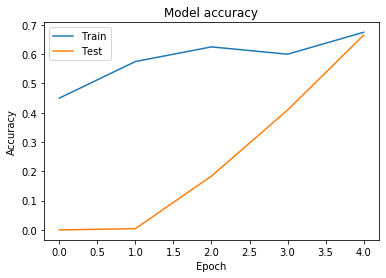

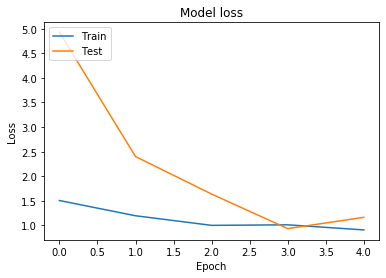

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import imageio
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [24]:
num_of_test_samples = 18000 
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(val_generator_test, num_of_test_samples // batch_size_phase_two,verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
matrix1 = confusion_matrix(val_generator_test.classes, y_pred)

1125/1125 [==============================] - 4173s 4s/step


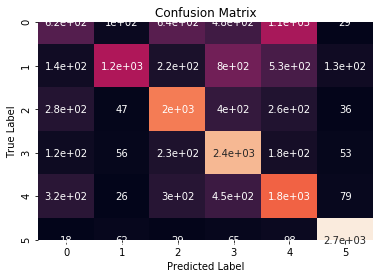

In [25]:
sns.heatmap(matrix1,annot=True,cbar=False);
plt.ylabel('True Label');
plt.xlabel('Predicted Label');
plt.title('Confusion Matrix');

In [26]:
print('\nClassification Report')
target_names = ['cloudy',
                 'haze',
                 'snow',
                 'rainy',
                 'thunder',
                 'sunny']
class_report = classification_report(val_generator_test.classes, y_pred, target_names=target_names)
print(class_report)


Classification Report
              precision    recall  f1-score   support

      cloudy       0.41      0.21      0.28      3000
        haze       0.80      0.39      0.53      3000
        snow       0.59      0.66      0.62      3000
       rainy       0.52      0.79      0.63      3000
     thunder       0.45      0.61      0.52      3000
       sunny       0.89      0.91      0.90      3000

    accuracy                           0.59     18000
   macro avg       0.61      0.60      0.58     18000
weighted avg       0.61      0.59      0.58     18000



In [29]:
#[row, column]
TP = matrix1[1, 1]
TN = matrix1[0, 0]
FP = matrix1[0, 1]
FN = matrix1[1, 0]

## Classification Error: Overall, how often is the classifier incorrect?

In [32]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print(classification_error)
print(1 - metrics.accuracy_score(val_generator_test.classes, y_pred))

0.11715686274509804
0.405


In [31]:
from sklearn import metrics

## Sensitivity: When the actual value is positive, how often is the prediction correct?

In [34]:
sensitivity = TP / float(FN + TP)

print(sensitivity)
print(metrics.recall_score(val_generator_test.classes, y_pred,average='micro'))

0.8962121212121212
0.595


## Specificity: When the actual value is negative, how often is the prediction correct?

In [35]:
specificity = TN / (TN + FP)

print(specificity)


0.8583333333333333


## Confusion matrix

In [36]:
print(metrics.confusion_matrix(val_generator_test.classes, y_pred))

[[ 618  102  635  475 1141   29]
 [ 137 1183  216  802  532  130]
 [ 280   47 1984  395  258   36]
 [ 121   56  232 2362  176   53]
 [ 316   26  295  449 1835   79]
 [  18   62   29   65   98 2728]]


In [42]:
probs = model.predict_proba(val_generator_test)

AttributeError: 'Model' object has no attribute 'predict_proba'

In [39]:
from sklearn.metrics import roc_curve, auc